In [2]:
:dep anyhow = "1.0.66"
:dep opencv = "0.70.0"
:dep image = "0.23"
:dep evcxr_image = "1.1.0"
:dep ndarray = "0.15.6"
:dep nalgebra = "0.31.2"
:dep cv-convert = { version = "0.21.2", features=["opencv_0-70", "image_0-23", "nalgebra_0-31", "ndarray_0-15"] }

use std::fs;
use std::path::{Path};
use anyhow::{anyhow, Result, Error};
use opencv::prelude::*;
use cv_convert::{FromCv, IntoCv, TryFromCv, TryIntoCv};
use image::{ImageBuffer, RgbImage, Rgb};
use evcxr_image::ImageDisplay;
use ndarray::prelude::*;

#[macro_use]
extern crate nalgebra as na;

fn opencv_imshow(img: &Mat) {
    let img_rgb = RgbImage::new(img.cols() as u32, img.rows() as u32);
    let data: Vec<u8> = img.data_bytes().unwrap().to_vec();
    let channels: u32 = img.channels() as u32;
    image::ImageBuffer::from_fn(img_rgb.width(), img_rgb.height(), | x, y | {
        let yi = y * img_rgb.width();
        let i: usize = ((x + yi) * channels) as usize;
        match channels {
            3 => {
                let b = data[i];
                let g = data[i + 1];
                let r = data[i + 2];
                image::Rgb([r, g, b])
            },
            _ => {
                let b = data[i];
                image::Rgb([b, b, b])
            }
        }
    }).evcxr_display()
}

let image_dir = "KU15627-Computer-Vision/images";

# Basic Template Matching

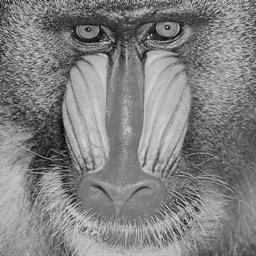

In [3]:
let image_path = Path::new(image_dir).join("Mandrill.bmp");
let img: Mat = opencv::imgcodecs::imread(image_path.to_str().unwrap(), opencv::imgcodecs::IMREAD_GRAYSCALE)?;
opencv_imshow(&img)

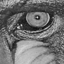

In [4]:
// let mut img_roi: opencv::core::Mat = Mat::roi(
//     &img,
//     opencv::core::Rect::new(128, 64, 64, 64))?;
// same result as img_roi
// let img_crop: opencv::core::Mat = Mat::rowscols(
//     &img,
//     &opencv::core::Range::new(64, 128)?, // rowr_ange
//     &opencv::core::Range::new(128, 192)?)?; //col_range
let img_crop: opencv::core::Mat = Mat::rowscols( // for mandrill.bmp
    &img,
    &opencv::core::Range::new(10, 74)?, // rowr_ange
    &opencv::core::Range::new(130, 194)?)?; //col_range
let mut img_template: opencv::core::Mat = Mat::new_rows_cols_with_default(64, 64, opencv::core::CV_8UC1, opencv::core::Scalar::all(0.))?;
img_crop.copy_to(&mut img_template)?;
opencv_imshow(&img_template)

In [5]:
let resource_size: opencv::core::Size = opencv::core::Size::new(img.cols() - img_template.cols(), img.rows() - img_template.rows());
println!("{:?}", &resource_size);

Size_ { width: 192, height: 192 }


# SSD(Sum of Squared Difference)

Mat { type: "CV_32FC1", flags: 1124024325, channels: 1, depth: "CV_32F", dims: 2, size: Size_ { width: 193, height: 193 }, rows: 193, cols: 193, elem_size: 4, elem_size1: 4, total: 37249, is_continuous: true, is_submatrix: false }
minVal: 0, minLoc: Point_ { x: 130, y: 10 }
maxVal: 25330108, maxLoc: Point_ { x: 41, y: 98 }
Mat { type: "CV_8UC3", flags: 1124024336, channels: 3, depth: "CV_8U", dims: 2, size: Size_ { width: 193, height: 193 }, rows: 193, cols: 193, elem_size: 3, elem_size1: 1, total: 37249, is_continuous: true, is_submatrix: false }


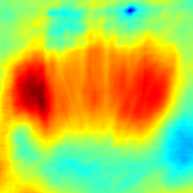

In [6]:
let mut ssd_result: Mat = Default::default();
opencv::imgproc::match_template(
    &img,
    &img_template,
    &mut ssd_result,
    opencv::imgproc::TM_SQDIFF,
    &opencv::core::no_array()
);
println!("{:?}", &ssd_result);
let mut ssd_result_min: f64 = Default::default();
let ssd_result_min_containter = Some(&mut ssd_result_min);
let mut ssd_result_max: f64 = Default::default();
let ssd_result_max_containter = Some(&mut ssd_result_max);
let mut ssd_result_min_loc: opencv::core::Point = Default::default();
let ssd_result_min_loc_containter: Option<&mut opencv::core::Point> = Some(&mut ssd_result_min_loc);
let mut ssd_result_max_loc: opencv::core::Point = Default::default();
let ssd_result_max_loc_containter: Option<&mut opencv::core::Point> = Some(&mut ssd_result_max_loc);
opencv::core::min_max_loc(
    &ssd_result,
    ssd_result_min_containter,
    ssd_result_max_containter,
    ssd_result_min_loc_containter,
    ssd_result_max_loc_containter,
    &opencv::core::no_array()
);
println!("minVal: {:}, minLoc: {:?}", &ssd_result_min, &ssd_result_min_loc);
println!("maxVal: {:}, maxLoc: {:?}", &ssd_result_max, &ssd_result_max_loc);
ssd_result = (&ssd_result / &ssd_result_max).into_result()?.to_mat()?;
let mut ssd_result_clamped_vec2: Vec<Vec<u8>> = Default::default();
for (p, v) in ssd_result.iter::<f32>()? {
    let new_v: f32 = v * 255.;
    if ssd_result_clamped_vec2.len() < (p.y + 1) as usize {
        ssd_result_clamped_vec2.push(vec![]);
    }
    ssd_result_clamped_vec2[p.y as usize].push(new_v.clamp(0., 255.) as u8);
}
let mut ssd_result_clamped_mat: Mat = Mat::from_slice_2d(&ssd_result_clamped_vec2)?;

let mut ssd_result_color_map: Mat = Default::default();
opencv::imgproc::apply_color_map(
    &ssd_result_clamped_mat,
    &mut ssd_result_color_map,
    opencv::imgproc::ColormapTypes::COLORMAP_JET as i32
);
println!("{:?}", &ssd_result_color_map);

opencv_imshow(&ssd_result_color_map)

If we apply abs calculation to clamped result, that make more accurate result.

Mat { type: "CV_8UC3", flags: 1124024336, channels: 3, depth: "CV_8U", dims: 2, size: Size_ { width: 193, height: 193 }, rows: 193, cols: 193, elem_size: 3, elem_size1: 1, total: 37249, is_continuous: true, is_submatrix: false }


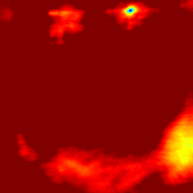

In [7]:
let mut ssd_result_clamped_vec2_f32: Vec<Vec<f32>> = Default::default();
for (p, v) in ssd_result.iter::<f32>()? {
    let new_v: f32 = v * 255.;
    if ssd_result_clamped_vec2_f32.len() < (p.y + 1) as usize {
        ssd_result_clamped_vec2_f32.push(vec![]);
    }
    ssd_result_clamped_vec2_f32[p.y as usize].push(new_v.clamp(0., 255.));
}
let mut ssd_result_clamped_mat_f32: Mat = Mat::from_slice_2d(&ssd_result_clamped_vec2_f32)?;

let mut img_ssd_result_f32_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&ssd_result_clamped_mat_f32, &mut img_ssd_result_f32_abs, 2., 0.);

let mut ssd_result_color_map: Mat = Default::default();
opencv::imgproc::apply_color_map(
    &img_ssd_result_f32_abs,
    &mut ssd_result_color_map,
    opencv::imgproc::ColormapTypes::COLORMAP_JET as i32
);
println!("{:?}", &ssd_result_color_map);

opencv_imshow(&ssd_result_color_map)

# SAD(Sum of Absolute Difference)

Mat { type: "CV_32FC1", flags: 1124024325, channels: 1, depth: "CV_32F", dims: 2, size: Size_ { width: 192, height: 192 }, rows: 192, cols: 192, elem_size: 4, elem_size1: 4, total: 36864, is_continuous: true, is_submatrix: false }
minVal: 0, minLoc: Point_ { x: 130, y: 10 }
maxVal: 270213, maxLoc: Point_ { x: 40, y: 91 }
Mat { type: "CV_8UC3", flags: 1124024336, channels: 3, depth: "CV_8U", dims: 2, size: Size_ { width: 192, height: 192 }, rows: 192, cols: 192, elem_size: 3, elem_size1: 1, total: 36864, is_continuous: true, is_submatrix: false }


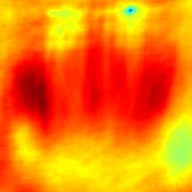

In [8]:
let mut img_f32: Mat = Default::default();
let mut img_template_f32: Mat = Default::default();
img.convert_to(&mut img_f32, opencv::core::CV_32FC1, 1., 0.);
img_template.convert_to(&mut img_template_f32, opencv::core::CV_32FC1, 1., 0.);

let mut sad_result: Mat = Mat::zeros_size(resource_size, opencv::core::CV_32FC1).unwrap().to_mat().unwrap();
    for h in 0..resource_size.height {
        for w in 0..resource_size.width {
            let mut diff: f32 = 0.0;
            let ch_end = h + img_template_f32.rows();
            let cw_end = w + img_template_f32.cols();
            for (i, ch) in (h..ch_end).enumerate() {
                for (j, cw) in (w..cw_end).enumerate() {
                    // if do sum(diff**2), it same return as SSD result.
                    diff += (img_template_f32.at_2d(i as i32, j as i32).unwrap_or(&0.0_f32) - img_f32.at_2d(ch, cw).unwrap_or(&0.0_f32)).abs();
                }
            }
            let mut target = sad_result.at_2d_mut::<f32>(h, w).unwrap();
            *target = diff;
        }
    }
println!("{:?}", &sad_result);
let mut sad_result_min: f64 = Default::default();
let sad_result_min_containter = Some(&mut sad_result_min);
let mut sad_result_max: f64 = Default::default();
let sad_result_max_containter = Some(&mut sad_result_max);
let mut sad_result_min_loc: opencv::core::Point = Default::default();
let sad_result_min_loc_containter: Option<&mut opencv::core::Point> = Some(&mut sad_result_min_loc);
let mut sad_result_max_loc: opencv::core::Point = Default::default();
let sad_result_max_loc_containter: Option<&mut opencv::core::Point> = Some(&mut sad_result_max_loc);
opencv::core::min_max_loc(
    &sad_result,
    sad_result_min_containter,
    sad_result_max_containter,
    sad_result_min_loc_containter,
    sad_result_max_loc_containter,
    &opencv::core::no_array()
);
println!("minVal: {:}, minLoc: {:?}", &sad_result_min, &sad_result_min_loc);
println!("maxVal: {:}, maxLoc: {:?}", &sad_result_max, &sad_result_max_loc);
sad_result = (&sad_result / &sad_result_max).into_result()?.to_mat()?;
let mut sad_result_clamped_vec2: Vec<Vec<u8>> = Default::default();
for (p, v) in sad_result.iter::<f32>()? {
    let new_v: f32 = v * 255.;
    if sad_result_clamped_vec2.len() < (p.y + 1) as usize {
        sad_result_clamped_vec2.push(vec![]);
    }
    sad_result_clamped_vec2[p.y as usize].push(new_v.clamp(0., 255.) as u8);
}
let mut sad_result_clamped_mat: Mat = Mat::from_slice_2d(&sad_result_clamped_vec2)?;

let mut sad_result_color_map: Mat = Default::default();
opencv::imgproc::apply_color_map(
    &sad_result_clamped_mat,
    &mut sad_result_color_map,
    opencv::imgproc::ColormapTypes::COLORMAP_JET as i32
);
println!("{:?}", &sad_result_color_map);

opencv_imshow(&sad_result_color_map)

Mat { type: "CV_8UC3", flags: 1124024336, channels: 3, depth: "CV_8U", dims: 2, size: Size_ { width: 192, height: 192 }, rows: 192, cols: 192, elem_size: 3, elem_size1: 1, total: 36864, is_continuous: true, is_submatrix: false }


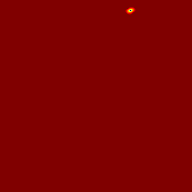

In [9]:
let mut img_sad_result_f32_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&sad_result_clamped_mat, &mut img_sad_result_f32_abs, 2., 0.);

let mut sad_result_color_map_abs: Mat = Default::default();
opencv::imgproc::apply_color_map(
    &img_sad_result_f32_abs,
    &mut sad_result_color_map_abs,
    opencv::imgproc::ColormapTypes::COLORMAP_JET as i32
);
println!("{:?}", &sad_result_color_map_abs);

opencv_imshow(&sad_result_color_map_abs)

# NCC

Mat { type: "CV_32FC1", flags: 1124024325, channels: 1, depth: "CV_32F", dims: 2, size: Size_ { width: 193, height: 193 }, rows: 193, cols: 193, elem_size: 4, elem_size1: 4, total: 37249, is_continuous: true, is_submatrix: false }
minVal: 0.8007628321647644, minLoc: Point_ { x: 25, y: 102 }
maxVal: 1, maxLoc: Point_ { x: 130, y: 10 }
Mat { type: "CV_8UC3", flags: 1124024336, channels: 3, depth: "CV_8U", dims: 2, size: Size_ { width: 193, height: 193 }, rows: 193, cols: 193, elem_size: 3, elem_size1: 1, total: 37249, is_continuous: true, is_submatrix: false }


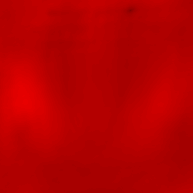

In [10]:
let mut ncc_result: Mat = Default::default();
opencv::imgproc::match_template(
    &img,
    &img_template,
    &mut ncc_result,
    opencv::imgproc::TM_CCORR_NORMED,
    &opencv::core::no_array()
);
println!("{:?}", &ncc_result);
let mut ncc_result_min: f64 = Default::default();
let ncc_result_min_containter = Some(&mut ncc_result_min);
let mut ncc_result_max: f64 = Default::default();
let ncc_result_max_containter = Some(&mut ncc_result_max);
let mut ncc_result_min_loc: opencv::core::Point = Default::default();
let ncc_result_min_loc_containter: Option<&mut opencv::core::Point> = Some(&mut ncc_result_min_loc);
let mut ncc_result_max_loc: opencv::core::Point = Default::default();
let ncc_result_max_loc_containter: Option<&mut opencv::core::Point> = Some(&mut ncc_result_max_loc);
opencv::core::min_max_loc(
    &ncc_result,
    ncc_result_min_containter,
    ncc_result_max_containter,
    ncc_result_min_loc_containter,
    ncc_result_max_loc_containter,
    &opencv::core::no_array()
);
println!("minVal: {:}, minLoc: {:?}", &ncc_result_min, &ncc_result_min_loc);
println!("maxVal: {:}, maxLoc: {:?}", &ncc_result_max, &ncc_result_max_loc);
// ncc_result = (&ncc_result / &ncc_result_max).into_result()?.to_mat()?;
ncc_result = ((&ncc_result + &Mat::new_rows_cols_with_default(
    ncc_result.cols(), ncc_result.rows(), opencv::core::CV_32FC1,
    opencv::core::Scalar::new(1.0, 1.0, 1.0, 1.0)).unwrap())/2.0).into_result()?.to_mat()?;
let mut ncc_result_clamped_vec2: Vec<Vec<u8>> = Default::default();
for (p, v) in ncc_result.iter::<f32>()? {
    let new_v: f32 = v * 255.;
    if ncc_result_clamped_vec2.len() < (p.y + 1) as usize {
        ncc_result_clamped_vec2.push(vec![]);
    }
    ncc_result_clamped_vec2[p.y as usize].push(new_v.clamp(0., 255.) as u8);
}
let mut ncc_result_clamped_mat: Mat = Mat::from_slice_2d(&ncc_result_clamped_vec2)?;

let mut ncc_result_color_map: Mat = Default::default();
opencv::imgproc::apply_color_map(
    &ncc_result_clamped_mat,
    &mut ncc_result_color_map,
    opencv::imgproc::ColormapTypes::COLORMAP_JET as i32
);
println!("{:?}", &ncc_result_color_map);

opencv_imshow(&ncc_result_color_map)

# ZNCC

Mat { type: "CV_32FC1", flags: 1124024325, channels: 1, depth: "CV_32F", dims: 2, size: Size_ { width: 193, height: 193 }, rows: 193, cols: 193, elem_size: 4, elem_size1: 4, total: 37249, is_continuous: true, is_submatrix: false }
minVal: -0.3732060492038727, minLoc: Point_ { x: 192, y: 192 }
maxVal: 1, maxLoc: Point_ { x: 130, y: 10 }
Mat { type: "CV_8UC3", flags: 1124024336, channels: 3, depth: "CV_8U", dims: 2, size: Size_ { width: 193, height: 193 }, rows: 193, cols: 193, elem_size: 3, elem_size1: 1, total: 37249, is_continuous: true, is_submatrix: false }


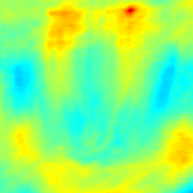

In [11]:
let mut zncc_result: Mat = Default::default();
opencv::imgproc::match_template(
    &img,
    &img_template,
    &mut zncc_result,
    opencv::imgproc::TM_CCOEFF_NORMED,
    &opencv::core::no_array()
);
println!("{:?}", &zncc_result);
let mut zncc_result_min: f64 = Default::default();
let zncc_result_min_containter = Some(&mut zncc_result_min);
let mut zncc_result_max: f64 = Default::default();
let zncc_result_max_containter = Some(&mut zncc_result_max);
let mut zncc_result_min_loc: opencv::core::Point = Default::default();
let zncc_result_min_loc_containter: Option<&mut opencv::core::Point> = Some(&mut zncc_result_min_loc);
let mut zncc_result_max_loc: opencv::core::Point = Default::default();
let zncc_result_max_loc_containter: Option<&mut opencv::core::Point> = Some(&mut zncc_result_max_loc);
opencv::core::min_max_loc(
    &zncc_result,
    zncc_result_min_containter,
    zncc_result_max_containter,
    zncc_result_min_loc_containter,
    zncc_result_max_loc_containter,
    &opencv::core::no_array()
);
println!("minVal: {:}, minLoc: {:?}", &zncc_result_min, &zncc_result_min_loc);
println!("maxVal: {:}, maxLoc: {:?}", &zncc_result_max, &zncc_result_max_loc);
// zncc_result = (&zncc_result / &zncc_result_max).into_result()?.to_mat()?;
zncc_result = ((&zncc_result + &Mat::new_rows_cols_with_default(
    zncc_result.cols(), zncc_result.rows(), opencv::core::CV_32FC1,
    opencv::core::Scalar::new(1.0, 1.0, 1.0, 1.0)).unwrap())/2.0).into_result()?.to_mat()?;
let mut zncc_result_clamped_vec2: Vec<Vec<u8>> = Default::default();
for (p, v) in zncc_result.iter::<f32>()? {
    let new_v: f32 = v * 255.;
    if zncc_result_clamped_vec2.len() < (p.y + 1) as usize {
        zncc_result_clamped_vec2.push(vec![]);
    }
    zncc_result_clamped_vec2[p.y as usize].push(new_v.clamp(0., 255.) as u8);
}
let mut zncc_result_clamped_mat: Mat = Mat::from_slice_2d(&zncc_result_clamped_vec2)?;

let mut zncc_result_color_map: Mat = Default::default();
opencv::imgproc::apply_color_map(
    &zncc_result_clamped_mat,
    &mut zncc_result_color_map,
    opencv::imgproc::ColormapTypes::COLORMAP_JET as i32
);
println!("{:?}", &zncc_result_color_map);

opencv_imshow(&zncc_result_color_map)